## Welcome to the `PSPNEt Blocks` Workshop!

In this workshop, we'll learn about PSPNet (Pyramid Scenare Parsing Network). It is built upon the idea of:
1. Providing a Global Context Prior 
2. Capturing Multi-scale features to identify objects of different scales

### Building blocks of PSPNet
- Pyramid Pooling Module for capturing Multi-scale features
- Auxiliary branch & loss function for Resnet backbones

We'll cover both the concepts in this notebook

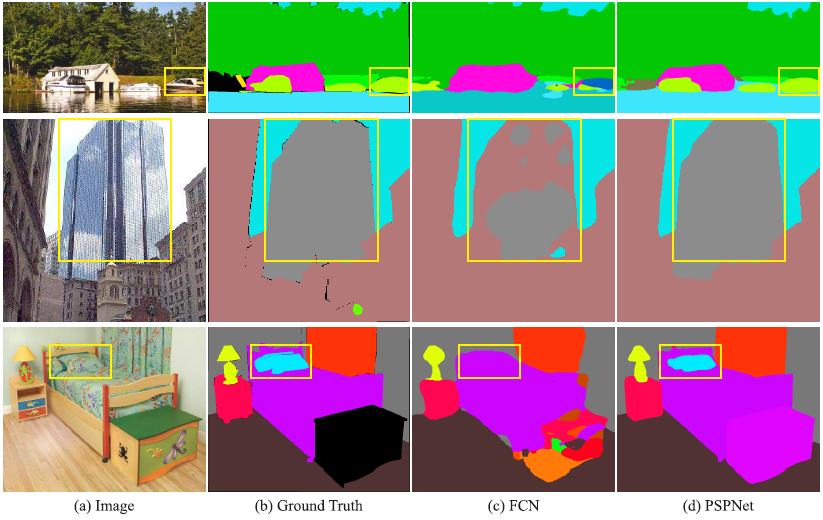

[ADE20k Dataset error analysis](https://arxiv.org/abs/1612.01105)

In [ ]:
# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

## Pyramid Pooling Module

- Pyramid Pooling Module helps to capture Features at Multiple scales
- It takes as input Feature map from the Backbone
- Condenses information spatially to fixed 2D output

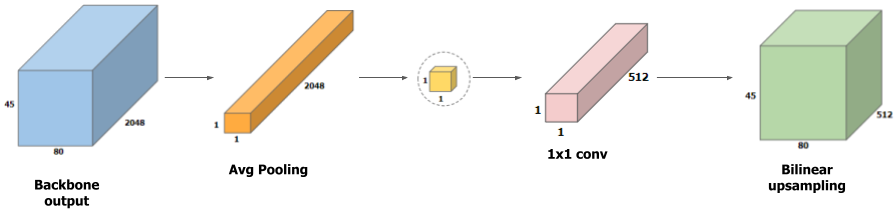

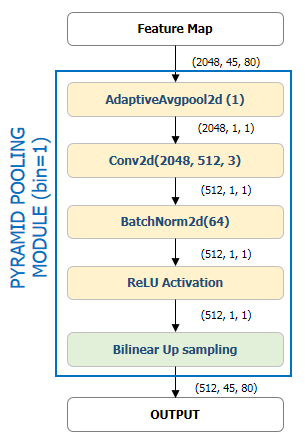

In [ ]:
class pyramid_pooling_module(nn.Module):
    def __init__(self, in_channels, out_channels, bin_sz):
        super(pyramid_pooling_module, self).__init__()
        self.ppm = nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_sz),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
    def forward(self, x):
        x_size = x.size()
        return F.interpolate(self.ppm(x), x_size[2:], mode='bilinear', align_corners=True)

In [ ]:
## Test with sample inputs
ppm_test_input = torch.Tensor(2, 2048, 45, 80)
model = pyramid_pooling_module(in_channels=2048, out_channels=512, bin_sz = 1)
ppm_test_output = model(ppm_test_input)
print("ppm_test_input.shape", ppm_test_input.shape)
print("ppm_test_output.shape", ppm_test_output.shape)

ppm_test_input.shape torch.Size([2, 2048, 45, 80])
ppm_test_output.shape torch.Size([2, 512, 45, 80])


- **Output from PPM with different scales are concatenated to provide multi-scale feature pyraming**

- **Skip-connecting the original feature map provides a rich global contextual prior**

## Auxiliary Branch

The authors proposed a separate auxiliary branch using `Layer3 output of Resnet backbones`.
- Auxiliary branch helps in setting initial values for the residual blocks.
- **Auxiliary branch is only used during training and not during inference**
- Auxiliary branch uses using similar classifier and loss function of the main branch. 
- $Total Loss = \alpha * (auxloss) + (1 - \alpha) * (mainloss)$
**Alpha is a hyperparameter. Authors used `alpha - 0.4**

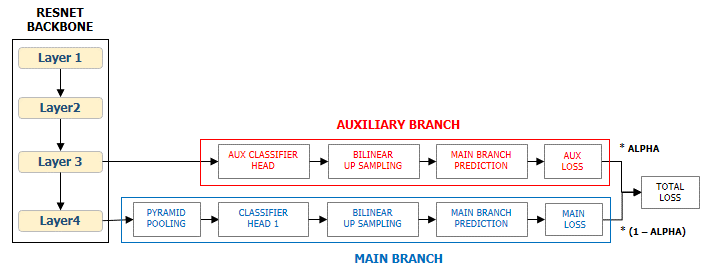

In [ ]:
class auxiliary_branch(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(auxiliary_branch, self).__init__()
        self.aux = nn.Sequential(
                    nn.Conv2d(in_channels , 256, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(p=0.1),
                    nn.Conv2d(256, num_classes, kernel_size=1)
                )
    def forward(self, x, img_size):
        return F.interpolate(self.aux(x), img_size, mode='bilinear', align_corners=False)

In [ ]:
## Test with sample inputs
## Layer3 of Resnet backbone has 1024 channels output
aux_test_input = torch.Tensor(2, 1024, 45, 80)
model = auxiliary_branch(in_channels=1024, num_classes=3)
aux_test_output = model(aux_test_input, img_size=(360,640))
print("aux_test_input.shape", aux_test_input.shape)
print("aux_test_output.shape", aux_test_output.shape)

aux_test_input.shape torch.Size([2, 1024, 45, 80])
aux_test_output.shape torch.Size([2, 3, 360, 640])


## Auxiliary Loss function

In [ ]:
class pspnet_loss(nn.Module):
    def __init__(self, num_classes, aux_weight):
        super(pspnet_loss, self).__init__()
        self.aux_weight = aux_weight
        self.loss_fn = smp.losses.DiceLoss('multiclass', 
                        classes=np.arange(num_classes).tolist(), log_loss = True, smooth=1.0)
    
    def forward(self, preds, labels):
        # if input predictions is in dict format
        # calculate total loss as weighted sum of 
        # main and auxiliary losses
        if(isinstance(preds, dict) == True):
            main_loss = self.loss_fn(preds['main'], labels)
            aux_loss = self.loss_fn(preds['aux'], labels)
            loss = (1 - self.aux_weight) * main_loss + self.aux_weight * aux_loss
        else:
            loss = self.loss_fn(preds, labels)
        return loss

**Useful resources for PSPNet**

- [Author Official pytorch implementation](https://github.com/hszhao/semseg/blob/master/model/pspnet.py)
- [Lextal implementation with pretrained backbones](https://github.com/Lextal/pspnet-pytorch)
- [IanTaehoon implementation](https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch/blob/master/segmentation/models/pspnet.py)